## Collaborative filtering

Consider a weighted bipartite graph were each set of vertices represents an entity such as *users* vs *products*. A (weighted) edge between two nodes normally means an interaction between the two entities. In our example, if a *user* and a certain *product* are connected it means that the *user* has acquired the *product* and has given it a rating (from 0 to 5, for example), which is represented by the weight of the edge. In collaborative filtering one tries to guess the weights of those pairs of vertices which are not connected, by considering those which are connected. 

### The content base approach

Imagine that we have some feature vector $X$ describing each product. Then for **each** user, we can train a linear regression model on those products that are connected to that user, using their features $X$ to predict their weights $y$.

Let $edge(u)$ be all products connected to the user $u$. Then as we saw in other notebooks, this is equivalent to minimizing the loss function: $L(w,b) = \frac{1}{2|edge(u)|}\sum_{(x,y)\in edge(u)} (f_{w,b}(x) - y)^{2}$, where $f_{w,b}(x) = \sum_{1}^{n} x_{i}w_{i} + b$ and $w$ and $b$ are the parameters of our model. 

In order to simplify this expression, let's write it in a matricial form, compressing the bias term. Let $X = (1,x_{1}, \dots, x_{n})$ and $W = (b,w_{1},\dots,w_{n})$, so $f_{W}(x) = WX^{t}$ and $L(W) = \frac{1}{2|edge(u)|}\sum_{(X,y)\in edge(u)} (WX^{t} - y)^{2}$. 

If we do this for all users, and aggregate their loss functions in one, we get:

$L(W_{1},\dots,W_{m}) = \sum_{i = 1}^{m}L(W_{i}) = \sum_{i = 1}^{m}(\frac{1}{2|edge(u_i)|}\sum_{(X,y)\in edge(u_i)} (W_{i}X^{t} - y)^{2})$. 

Since now we are iterating through each edge of the graph, we can group the two summands in just one (per edge), and therefore:

$L(W) = \frac{1}{2}\sum_{(W,X,y)\in E} (WX^{t} - y)^{2}$, where each edge $E$ from $user$ to $product$ is a triplet $(W,X,y)$, where $W$ is the model of the user, $X$ the features of the product and $y$ the weight of the edge


Of course, since the $W_{i}$ only depends on the user $i$, it is exactly the same to minimize each loss function for each user independently or to minimize the sum of all of them together. 

### The collaborative approach

The problem is that, in general, one does not have the vector of features $X$ for each product, since computing it is very costly. The collaborative filtering approach is based on modeling these vectors $X$s along with their respective user models $W$s. So the loss function defined above does not depend only on the user models $W_{1},\dots,W_{m}$ but also on the feature vectors of the products, $X_{1},\dots X_{m'}$, so we simply try to minimize:

$L(W_{1},\dots,W_{m},X_{1},\dots X_{m'})$

As in other notebooks, we want to use gradient descent to do that, and therefore we want to compute the partial derivative of $L$ with respect to each of its variables. In particular:

$\frac{\partial L}{\partial W_{i}} = \frac{1}{2}\sum_{(W_{i},X,y)\in E} (W_{i}X^{t} - y)X$

$\frac{\partial L}{\partial X_{j}} = \frac{1}{2}\sum_{(W,X_{j},y)\in E} (WX_{j}^{t} - y)W$

Of course, we need to initialize $W$ and $X$ to certain random (small) values and we need to define $n$ the number of features and therefore dimensions of $W$ and $X$. Let's do an example, with an [imdb movie ratings dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset#ratings_small.csv).

In [132]:
import pandas as pd
import numpy as np
ratings = pd.read_csv("ratings_small.csv")

In [65]:
# number of features
n = 5
# size of one set of vertices
n_users = len(ratings.userId.unique())
# size of the other set of vertices
n_products = len(ratings.movieId.unique())

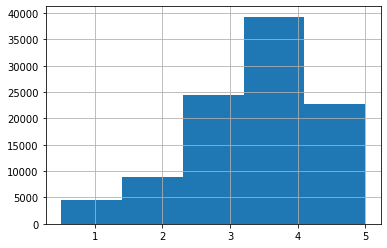

In [38]:
%matplotlib inline

ratings.rating.hist(bins=5)

In [142]:
graph = np.asarray(ratings.pivot(index="userId",columns = "movieId",values = "rating"))
movie_ids = ratings.pivot(index="userId",columns = "movieId",values = "rating").axes[1]
graph = np.asarray(graph)

Here is the adjency matrix of the bipartite graph:

In [21]:
graph.shape

(671, 9066)

Let's pick some edges of the graph for evaluation:

In [75]:
# These are the positions of the non null edges in the matrix
not_null_edges = np.where(~pd.isnull(graph))
total_edges = len(not_null_edges[0])
# Pick the 20% of them for evaluation
eval_edges_pos = np.random.randint(low = 0,high=len(not_null_edges[0]),size=int(total_edges*0.8))
eval_y = graph[(not_null_edges[0][eval_edges_pos],not_null_edges[1][eval_edges_pos])]
# Create two graphs, one for training and one for evaluation
train_graph = graph.copy()
eval_graph = graph.copy()
eval_graph[:,:] = np.nan
#Remove the edges of evaluation from the graph for training
train_graph[(not_null_edges[0][eval_edges_pos],not_null_edges[1][eval_edges_pos])] = np.nan
#Add the edges for evaluation for the graph for evaluating
eval_graph[(not_null_edges[0][eval_edges_pos],not_null_edges[1][eval_edges_pos])] = eval_y

In [69]:
n_train = len(np.where(~pd.isnull(train_graph))[0])
n_eval = len(np.where(~pd.isnull(eval_graph))[0])

Implement a gradient descend strategy to find a minimum. Run it for 500 iterations:

In [127]:
def gradient_descend(its):
    #initialize the models and features matrices
    W = np.random.rand(n_users,n)
    X = np.random.rand(n_products,n)
    metris = []
    for i in range(its):
        if i%100==0:
            print(i)
        #WX - y 
        train_dif_pred_true = (np.dot(W,X.T) - train_graph)
        eval_dif_pred_true = (np.dot(W,X.T) - eval_graph)
        #WX - y with nans imputed as 0
        dif_pred_true_imputed_0  = train_dif_pred_true.copy()
        dif_pred_true_imputed_0[np.where(pd.isnull(dif_pred_true_imputed_0))] = 0
        #Train loss
        L_train = 0.5*np.nansum(train_dif_pred_true**2) / n_train
        #Eval loss
        L_eval = 0.5*np.nansum(eval_dif_pred_true**2) / n_eval

        metrics.append({"loss":L_train,"iter":i,"set":"train"})
        metrics.append({"loss":L_eval,"iter":i,"set":"eval"})
        #dX = (WX - y)*W
        dX = 0.5*np.dot(dif_pred_true_imputed_0.T,W)
        #dW = (WX - y)*X
        dW = 0.5*np.dot(dif_pred_true_imputed_0,X)
        #gradient descend step
        X = X - 0.001*dX
        W = W - 0.001*dW

    return metrics,X,W

In [82]:
metrics, X, W = gradient_descend(its = 500)

0
100
200
300
400


Plot the evolution of the loss of eval and train with the gradient descend steps:

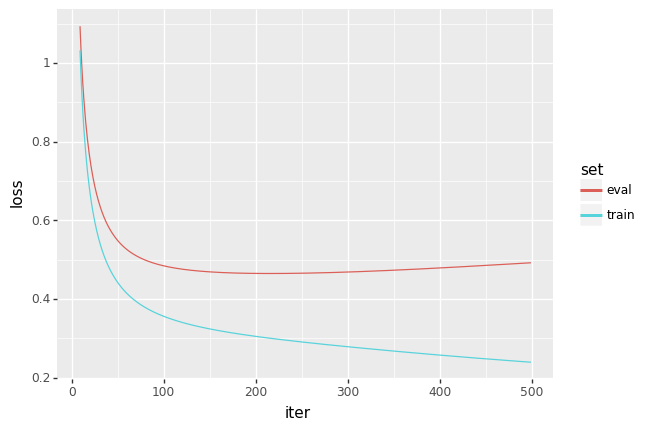

<ggplot: (285734225)>

In [73]:
from plotnine import *
metrics = pd.DataFrame(metrics)
ggplot(metrics[metrics["iter"]>8]) + geom_line(aes(x="iter",y = "loss",color = "set"))

As expected, the train loss consistenly descends and the eval one descends for the first 150 iterations and then starts to increase again. This is obviously overfitting and therefore we should *early stop* the algorithm after 150 its.



In [128]:
metrics, X, W = gradient_descend(its = 150)

0
100


Now, to understand if the model is working well, for a given movie, let's try to find those that have similar features. To do that we need to merge the original dataset (which only has `movieIds`) with [this](https://www.kaggle.com/rounakbanik/the-movies-dataset#links_small.csv) and [this one](https://www.kaggle.com/rounakbanik/the-movies-dataset#movies_metadata.csv):

In [85]:
movie_data = pd.read_csv("movies_metadata.csv")
movie_links = pd.read_csv("links_small.csv")

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [86]:
movie_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [90]:
ratings.shape

(100004, 4)

In [144]:
ratings = pd.merge(ratings,movie_links, on = ["movieId"], how = "left")

In [145]:
ratings.shape

(100004, 6)

In [146]:
movie_data["imdbId"] = movie_data["imdb_id"].astype(str).apply(lambda x: x.strip("tt")).astype("float64")

In [147]:
ratings = pd.merge(ratings,movie_data[["original_title","imdbId"]], on = ["imdbId"], how = "left")

In [148]:
ratings.head()

,userId,movieId,rating,timestamp,imdbId,tmdbId,original_title
0,1,31,2.5,1260759144,112792,9909.0,Dangerous Minds
1,1,1029,3.0,1260759179,33563,11360.0,Dumbo
2,1,1061,3.0,1260759182,117665,819.0,Sleepers
3,1,1129,2.0,1260759185,82340,1103.0,Escape from New York
4,1,1172,4.0,1260759205,95765,11216.0,Nuovo Cinema Paradiso


Now, for each set of movies, compute the euclidean distance between their features:

In [149]:
X-

array([[0.24151084, 0.88620116, 1.08463176, 0.42388025, 0.77823784],
       [0.92033469, 0.56511194, 0.86467724, 0.37682874, 0.53130726],
       [0.35309347, 1.02039429, 0.53595548, 0.58133718, 0.57352218],
       ...,
       [0.6370345 , 0.83710382, 0.70049109, 0.42592349, 0.85772037],
       [0.54273103, 0.40463388, 0.79950638, 0.80133847, 0.89316129],
       [0.48722817, 0.19044246, 0.90436759, 0.83594979, 0.65213673]])

In [115]:
movie_data["imdbId"]

0         114709.0
1         113497.0
2         113228.0
3         114885.0
4         113041.0
           ...    
45461    6209470.0
45462    2028550.0
45463     303758.0
45464       8536.0
45465    6980792.0
Name: imdbId, Length: 45466, dtype: float64